In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [15]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import scipy

from load_dataset import Dataset
import plotting

In [4]:
def accor_adfuller(data, lags=None):
    _, p_value = diagnostic.acorr_ljungbox(data.dropna(), lags=lags)
    print(min(p_value), max(p_value))
    print(adfuller(data.dropna())[1])

In [57]:
def test_adfuler(data):
    test = adfuller(data.dropna())
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [38]:
data = pd.read_csv('sbrf.csv', index_col='TRADEDATE', parse_dates=True)
data = data ['CLOSE'].dropna()

<AxesSubplot:xlabel='TRADEDATE'>

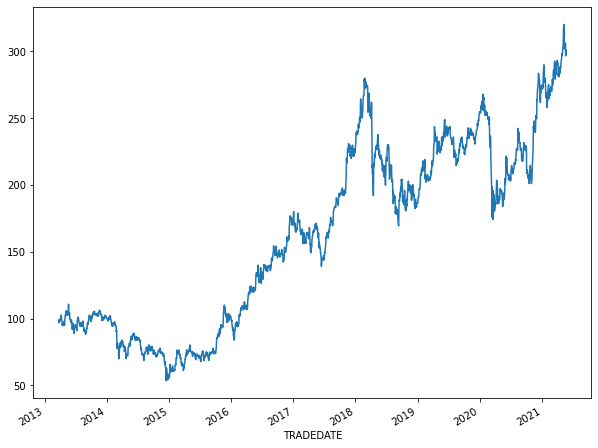

In [39]:
data.plot(figsize=(10, 8))

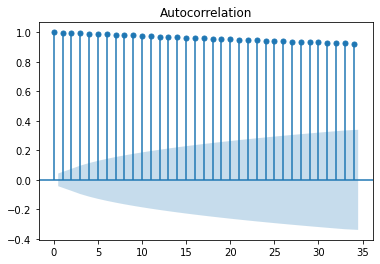

In [40]:
tsaplots.plot_acf(data);

In [8]:
# проверим автокорреляция при помощи теса Ланга-Бокса
_, p_value = diagnostic.acorr_ljungbox(data)

D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [9]:
# видим, что значения p-value сильно ниже порога (обычно 0.05, 0.01), значит мы смело отвергаем нулевую гипотезу
# то есть данные явно не случайны
max(p_value), min(p_value)

(0.0, 0.0)

In [58]:
# проверим ряд на стационарость критерием Дики-Фуллера
# видим, что p-value сильно выше порога, значит мы никак не можем отвергнуть нулевую гипотезу, следовательно -
# ряд не стационарен
test_adfuler(data)

adf:  -0.31840363184366355
p-value:  0.92285708151608
Critical values:  {'1%': -3.4335345735350664, '5%': -2.862946794168607, '10%': -2.567518913543354}
есть единичные корни, ряд не стационарен


adf:  -0.5307704990744758
p-value:  0.8858706876016496
Critical values:  {'1%': -3.4335345735350664, '5%': -2.862946794168607, '10%': -2.567518913543354}
есть единичные корни, ряд не стационарен


<AxesSubplot:xlabel='TRADEDATE'>

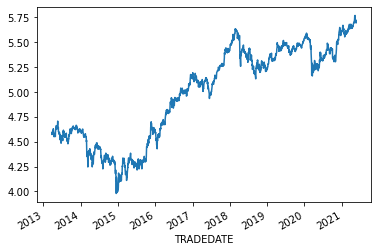

In [59]:
# Попробуем сделать его стационарным
# Для начала постараемся избавиться от гетероскедастичности, взяв логарифм
data_log = np.log(data)
test_adfuler(data_log)
data_log.plot()

adf:  -15.639088377223556
p-value:  1.648863195917372e-28
Critical values:  {'1%': -3.4335345735350664, '5%': -2.862946794168607, '10%': -2.567518913543354}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='TRADEDATE'>

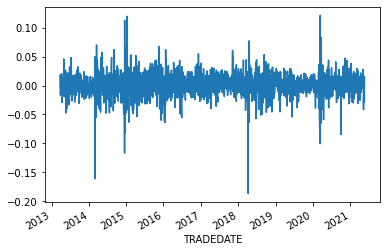

In [60]:
# чтож, попробуем применить дифференцирование
data_diff = data_log.diff()
test_adfuler(data_diff)
data_diff.plot()

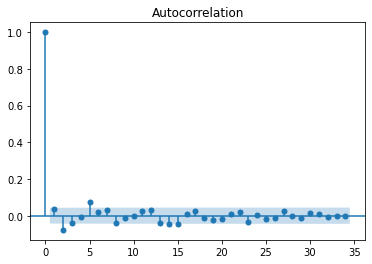

In [61]:
tsaplots.plot_acf(data_diff.dropna());

adf:  -16.222782101411447
p-value:  3.8824257670552074e-29
Critical values:  {'1%': -3.4335690618996733, '5%': -2.862962021283546, '10%': -2.5675270211517285}
единичных корней нет, ряд стационарен


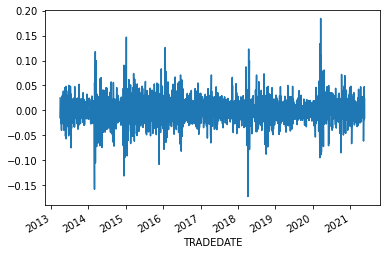

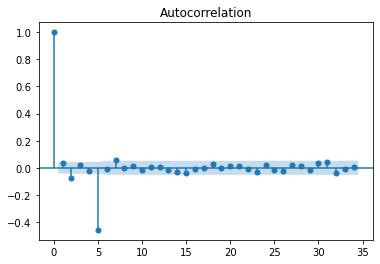

In [74]:
data_season_diff = data_diff.diff(5)
test_adfuler(data_season_diff)
data_season_diff.plot()
tsaplots.plot_acf(data_season_diff.dropna());

In [80]:
data_season_diff.dropna()[:5]

TRADEDATE
2013-04-02    0.024957
2013-04-03    0.011290
2013-04-04   -0.015631
2013-04-05   -0.007042
2013-04-08    0.017521
Name: CLOSE, dtype: float64

In [86]:
#обратное преобразование
from pmdarima.utils import diff_inv
# data_diff_1 = data_season_diff.cumsum(5)
# data_diff_1.plot()

ImportError: cannot import name 'six' from 'sklearn.externals' (D:\Anaconda3\envs\ts_summer\lib\site-packages\sklearn\externals\__init__.py)

In [84]:
data_diff_1.dropna()[:5]

TRADEDATE
2013-04-02    0.024957
2013-04-03    0.036246
2013-04-04    0.020615
2013-04-05    0.013573
2013-04-08    0.031094
Name: CLOSE, dtype: float64

<AxesSubplot:xlabel='TRADEDATE'>

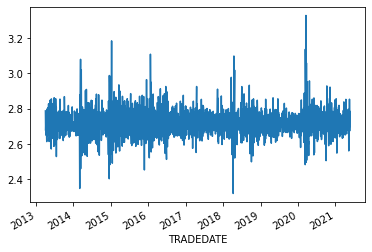

In [78]:
data_log = np.exp(data_diff_1)
data_log.plot()